In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm.notebook import tqdm
import itertools
import os
import json
from collections import defaultdict
import itertools
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.ParserWarning)

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns
import scipy.stats as stats
import copy
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
import sys
%cd -q top-k-mallows
import permutil as pu
%cd -q ../..
from utils import *

# Each version of the dataset in the form of :

$$Score_1 = \begin{bmatrix} &  T_{1} & \cdots & T_{|T|}\\
S_1 & \cdots & \cdots & \cdots \\
S_2 & \cdots &\cdots & \cdots \\
\cdots &\cdots &\cdots& \cdots \\
S_{|S|} & \cdots& \cdots& \cdots  \\
\end{bmatrix}$$, 

where each score of the task is a column of the matrix

Currently I have collected data for [GLUE](https://openreview.net/pdf?id=rJ4km2R5t7) , [SUPERGLUE](https://arxiv.org/abs/1905.00537) , [XTREME](https://arxiv.org/pdf/2104.07412.pdf) 

### Global analysis

In [2]:
DATASETS = ['xtrem','glue','superglue'] # available datasets
number = 0 # which dataset to load

In [3]:
count = 0
for ds in  DATASETS:
    print('Loading',ds)
    df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
    df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1]) #filter columns
    count +=  df.shape[0]* df.shape[1]
    print('Shape',df.shape)
print('Number of points',count)

Loading xtrem
Shape (15, 5)
Loading glue
Shape (105, 15)
Loading superglue
Shape (24, 15)
Number of points 2010


In [4]:
print('Loading', DATASETS[number])
df =  pd.read_csv('data/{}.data'.format(DATASETS[number]),index_col=False)
df =  pd.read_csv('data/{}.data'.format(DATASETS[number]),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1]) #filter columns

Loading xtrem


In [5]:
#my guess for this function but the values don't match with the old file
distorsion_measure =  lambda x, y : sum([pu.distance(x,i) for i in y])/len(y)

In [6]:
rankings = []
for index,columns in df.iteritems():
    if index != 'Model':
        rankings.append(columns.argsort().argsort().values.tolist())

ranking_borda = ranking_aggregation(df).tolist()
print('Borda Distorsion', distorsion_measure(ranking_borda,rankings)) #the old file printed 12.25
#print(np.array(rankings))
#print(np.array(ranking_borda))
ranking_mean = mean_aggregation_task_level(df)[0].tolist()
print('Mean Distorsion', distorsion_measure(ranking_mean,rankings)) #the old file printed 12.75
#print(ranking_mean)
random_correlation_measures = []
list_to_permute = list(range(len(ranking_mean)))
for i in tqdm(range(100)): # generate 100 random permutations
    random.shuffle(list_to_permute)
    random_correlation_measures.append( distorsion_measure(list_to_permute,rankings))

print('Mean Random Distorsion', sum(random_correlation_measures)/len(random_correlation_measures))

Borda Distorsion 10.75
Mean Distorsion 10.75


  0%|          | 0/100 [00:00<?, ?it/s]

Mean Random Distorsion 51.645


In [7]:
VISUALIZE_RANKING = False
if VISUALIZE_RANKING:
    df = df.set_index('Model') # display data
    mean_ranking,means = mean_aggregation_task_level(df)
    print('Ranking Mean',mean_ranking)
    print('Means Scores',means)
    ranking_borda,borda_count = ranking_aggregation(df,True)
    print('Ranking Borda',ranking_borda)
    print('Borda Count',borda_count)
    df.head(20)

#### Analyse the ranking 

In [37]:
mean_ranking,means = mean_aggregation_task_level(df)
#mean_reindex = reverse_ranking(mean_ranking)[::-1] 
mean_reindex = np.argsort(-np.array(means))
print('Ranking mean',mean_ranking)
print('Means',means)
print('ranking_borda_reindex',mean_reindex)

Ranking mean [14 13 11 10 12  9  7  6  8  5  3  4  2  0  1]
Means [83.2   82.65  80.55  80.275 80.625 79.675 79.175 79.025 79.45  78.6
 76.225 78.325 73.5   60.075 61.95 ]
ranking_borda_reindex [ 0  1  4  2  3  5  8  6  7  9 11 10 12 14 13]


In [9]:
df_new = df.reindex(mean_reindex,copy = False)
df_new.reset_index(inplace=True)
del df_new['index']

In [10]:
df_new.head(20)

,Model,Classification,\tStructured Prediction,\tQuestion Answering,\tSentence Retrieval
0,Turing ULR v5\tAlexander v-team\tMicrosoft\tNo...,84.5,90.3,81.7,76.3
1,CoFe\tHFL\tiFLYTEK\tOct 26 2021\t ...,84.1,90.1,81.4,75.0
2,Polyglot\tMLNLC\tByteDance\tApr 29 2021\t ...,81.7,88.3,80.6,71.9
3,InfoXLM-XFT\tNoah's Ark Lab\tHuawei\tOct 5 20...,82.2,89.3,75.5,75.2
4,VECO + HICTL\tAliceMind + MT\tAlibaba\tSep 21 ...,82.0,89.0,76.7,73.4
5,Unicoder + ZCode\tMSRA + Cognition\tMicrosoft\...,81.6,88.4,76.2,72.5
6,T-ULRv2 + StableTune\tTuring\tMicrosoft\tOct 7...,80.7,88.8,75.4,72.9
7,ERNIE-M\tERNIE Team\tBaidu\tJan 1 2021\t ...,80.9,87.9,75.6,72.3
8,HiCTL\tDAMO MT Team\tAlibaba\tMar 21 2021\t ...,80.8,89.0,74.4,71.9
9,Anonymous3\tAnonymous3\tAnonymous3\tJan 3 202...,79.9,88.2,74.6,71.7


In [11]:
ranking_borda,borda_count = ranking_aggregation(df_new,True)
#ranking_borda_reindex = reverse_ranking(ranking_borda)[::-1]
ranking_borda_reindex = np.argsort(-np.array(ranking_borda))
print('Ranking Borda',ranking_borda)
print('Count Borda',borda_count)
print('ranking_borda_reindex',ranking_borda_reindex)
print('Sorted Borda Ciount',sorted(borda_count)[::-1])

Ranking Borda [14 13  9 12 11 10  8  6  7  4  5  3  2  1  0]
Count Borda [55 50 34 44 42 35 31 29 29 21 22 15  9  3  1]
ranking_borda_reindex [ 0  1  3  4  5  2  6  8  7 10  9 11 12 13 14]
Sorted Borda Ciount [55, 50, 44, 42, 35, 34, 31, 29, 29, 22, 21, 15, 9, 3, 1]


In [12]:
df_new.reindex(ranking_borda_reindex).head(40)

,Model,Classification,\tStructured Prediction,\tQuestion Answering,\tSentence Retrieval
0,Turing ULR v5\tAlexander v-team\tMicrosoft\tNo...,84.5,90.3,81.7,76.3
1,CoFe\tHFL\tiFLYTEK\tOct 26 2021\t ...,84.1,90.1,81.4,75.0
3,InfoXLM-XFT\tNoah's Ark Lab\tHuawei\tOct 5 20...,82.2,89.3,75.5,75.2
4,VECO + HICTL\tAliceMind + MT\tAlibaba\tSep 21 ...,82.0,89.0,76.7,73.4
5,Unicoder + ZCode\tMSRA + Cognition\tMicrosoft\...,81.6,88.4,76.2,72.5
2,Polyglot\tMLNLC\tByteDance\tApr 29 2021\t ...,81.7,88.3,80.6,71.9
6,T-ULRv2 + StableTune\tTuring\tMicrosoft\tOct 7...,80.7,88.8,75.4,72.9
8,HiCTL\tDAMO MT Team\tAlibaba\tMar 21 2021\t ...,80.8,89.0,74.4,71.9
7,ERNIE-M\tERNIE Team\tBaidu\tJan 1 2021\t ...,80.9,87.9,75.6,72.3
10,Creative\tCreative\tMicrosoft\tSep 8 2021\t ...,76.5,86.3,90.8,59.7


In [13]:
df_new.reindex(ranking_borda_reindex).mean(axis=1,numeric_only=True).head(20)

0     83.200
1     82.650
3     80.550
4     80.275
5     79.675
2     80.625
6     79.450
8     79.025
7     79.175
10    78.325
9     78.600
11    76.225
12    73.500
13    61.950
14    60.075
dtype: float64

## Robutness experiement when removing metrics

In [14]:
def generate_metric_experiments_benchmark(number_of_samples,ds,seed=42):
    df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
    #df.dropna(inplace=True,axis=1)
    considered_df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1])
    considered_df =considered_df.set_index(['Model'])
    print('columns',considered_df.columns)
    considered_columns = list(considered_df.columns)
    random.seed(seed)
    final_dic = {
        'mean':{},
        'ranking':{}
    }
    for i in range(1,len(considered_columns)+1):
        final_dic['mean']['{}'.format(i)] = []
        final_dic['ranking']['{}'.format(i)] = []

    for _ in tqdm(range(number_of_samples),'Nbs of Experiments'):
        random.shuffle(considered_columns)
        for i in range(1,len(considered_columns)+1):
            running_df =  considered_df[considered_columns[:i]]
            c_mean= mean_aggregation_task_level(running_df)[0]
            c_ranking = ranking_aggregation(running_df)
            final_dic['mean']['{}'.format(i)].append(c_mean)
            final_dic['ranking']['{}'.format(i)].append(c_ranking)
    return final_dic,len(considered_columns)

In [15]:
def compute_results_experiments_benchmark(final_dic,ds,len_norm):
    df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
    considered_df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1])
    print('columns',considered_df.columns)
    considered_df =considered_df.set_index(['Model'])
    
    scores_to_plot = {
    'criterion': [],
    'method': [],
    'correlation': [],
        'kendallTau': [],
    }
    ref_ranks = {
         'mean': mean_aggregation_task_level(considered_df)[0],
        'ranking':  ranking_aggregation(considered_df)
    }
    for k,v in final_dic.items(): 
        ref_rank = ref_ranks[k]
        for sub_k,sub_v in tqdm(v.items(),'Itterations'):
            for score in sub_v:
                scores_to_plot['criterion'].append(int(sub_k) / (len_norm) )
                scores_to_plot['method'].append(k)
                scores_to_plot['correlation'].append(stats.kendalltau(score, ref_rank)[0])
                scores_to_plot['kendallTau'].append(stats.kendalltau(score, ref_rank))
    return scores_to_plot

In [16]:
GENERATE_DATA_ROBUTNESS_METRIC  = False

In [17]:
if GENERATE_DATA_ROBUTNESS_METRIC:    
    seed = 40
    number_of_samples = 1000
    for ds in DATASETS:
        print(ds)
        final_dic,len_norm = generate_metric_experiments_benchmark(number_of_samples,ds,seed=42)
        json_results = compute_results_experiments_benchmark(final_dic,ds,len_norm)
        with open('result_benchmark_metric_{}_{}.json'.format(ds,number_of_samples),'w') as file:
            json.dump(json_results,file)

        plt.figure(figsize=(12,8))
        df_to_plot = pd.DataFrame(json_results)
        sns.lineplot(x="criterion", y="correlation", hue="method",data=df_to_plot)
        plt.title('{} {}'.format(ds,number_of_samples))
        plt.show()



xtrem


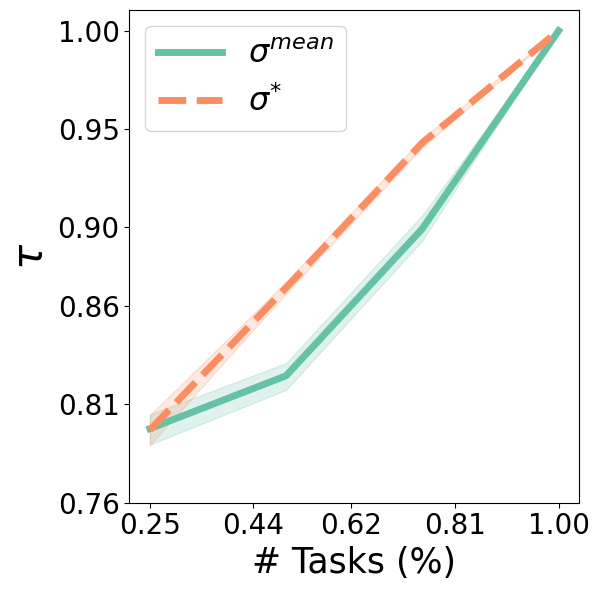

In [18]:
considered_ds = DATASETS[0]
print(considered_ds)
assert considered_ds in DATASETS
number_of_samples = 1000   
with open('result_benchmark_metric_{}_{}.json'.format(considered_ds,number_of_samples),'r') as file:
        json_results = json.load(file)
#print(json_results)
df_to_plot = pd.DataFrame(json_results)
#print(df_to_plot)
sns.set_palette("Set2")
fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)
plt.yticks(fontsize=20) #hue="losses",
plt.xticks(fontsize=20) #hue="losses",
    #plt.title('{}'.format(title),fontsize=30)
plt.ylabel('$\\tau$',fontsize=30)
plt.xlabel('# Tasks (%)',fontsize=25)
plt.tight_layout()
L=plt.legend(fontsize=23)
for line in L.get_lines():
    line.set_linewidth(5.0)
#L.get_texts()[0].set_text('Aggreg.')
L.get_texts()[0].set_text('$\\sigma^{mean}$')
L.get_texts()[1].set_text('$\\sigma^{*}$')

N = 6
ax.set_yticks(np.round(np.linspace(0.76, 1, N), 2))

N = 5
ax.set_xticks(np.round(np.linspace(0.25 if 'xtrem' in considered_ds else 0, 1, N), 2))
plt.savefig('one_level_ranking_{}.pdf'.format(considered_ds),format='pdf')
plt.show()


## Robutness experiement when adding systems

In [19]:
def generate_system_experiment_benchmark(number_of_samples,path= 'final_df',ds='xtrem',seed=42):
    random.seed(seed)
    l_final_dic = []
    df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
    data_df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1])
    data_df =data_df.set_index(['Model'])
    number_of_systems = len(copy.deepcopy(list(set(data_df.reset_index().Model.values)))) +1
    for number_of_systems in tqdm(range(1,number_of_systems + 1),'Number of Systems'): # start at 2
        for _ in tqdm(range(number_of_samples),'Experiments'):
            df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
            data_df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1])
            data_df =data_df.set_index(['Model'])
            systems = copy.deepcopy(list(set(data_df.reset_index().Model.values)))
            random.shuffle(systems)
            df = data_df[data_df.index.isin(systems, level=0)]
            df = df.reindex(systems)
            ref_ranks = {
             'mean':mean_aggregation_task_level(df)[0][:number_of_systems],
            'direct': ranking_aggregation(df)[:number_of_systems],
                    }
            selected_systems = systems[:number_of_systems]
            running_df = df[df.index.isin(selected_systems, level=0)]
            running_df_new = running_df.reindex(selected_systems)


            runing_ranks = {
             'mean':mean_aggregation_task_level(running_df)[0],
            'direct': ranking_aggregation(running_df)
                    }

            final_dic = {}

            for r_key in ref_ranks.keys():
                    final_dic['{}'.format(r_key)] = stats.kendalltau(ref_ranks[r_key], runing_ranks[r_key])[0]
            l_final_dic.append(final_dic)  
    return l_final_dic

In [20]:
GENERATE_DATA_ROBUTNESS_SYSTEM  = False

In [21]:
if GENERATE_DATA_ROBUTNESS_SYSTEM:
    for ds in DATASETS: 
        number_of_samples = 15
        l_final_dic = generate_system_experiment_benchmark(number_of_samples,path= 'final_df',ds=ds,seed=42) 
        df_dic = {
                'type':[],
                'correlation':[],
                'nbs':[]
            }
        for index,c_dic in enumerate(l_final_dic):
            index_runing=index // number_of_samples 
            for k,v in c_dic.items():
                    df_dic['nbs'].append(index_runing)
                    df_dic['type'].append(k)
                    df_dic['correlation'].append(v)
        with open('final_dic_ajout_de_systems_{}_{}_benchmarks.json'.format(ds,number_of_samples),'w') as file:
            json.dump(l_final_dic,file)
        plt.figure(figsize=(12,8))
        df_to_plot = pd.DataFrame(df_dic)
        sns.lineplot(x="nbs", y="correlation", hue="type",data=df_to_plot)
        plt.title('{}'.format(ds))
        plt.show()

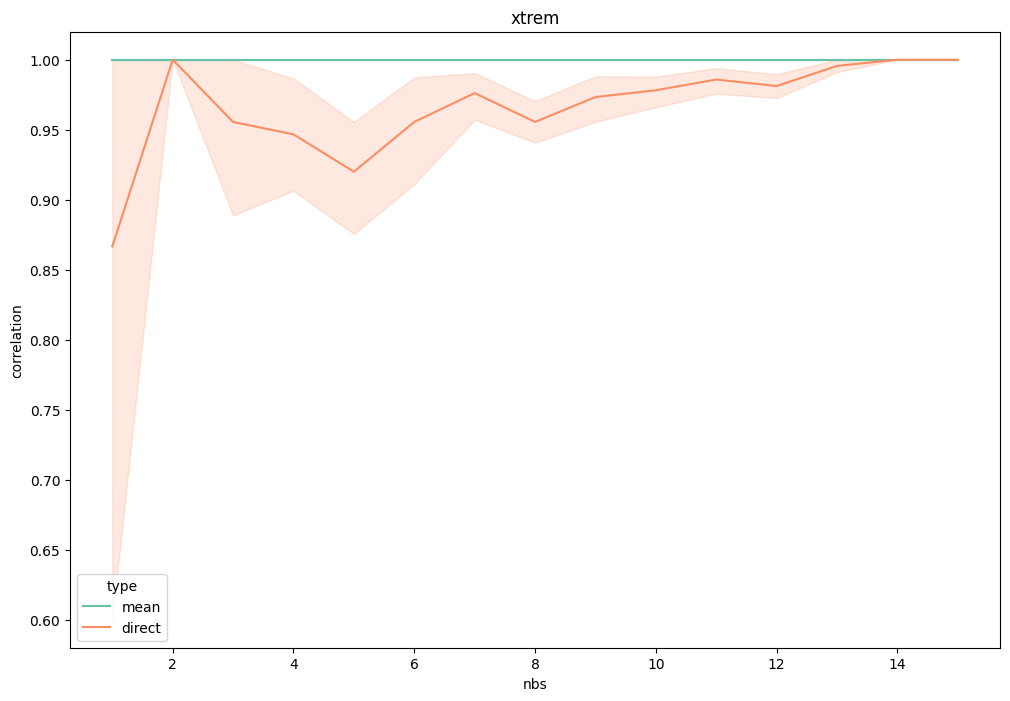

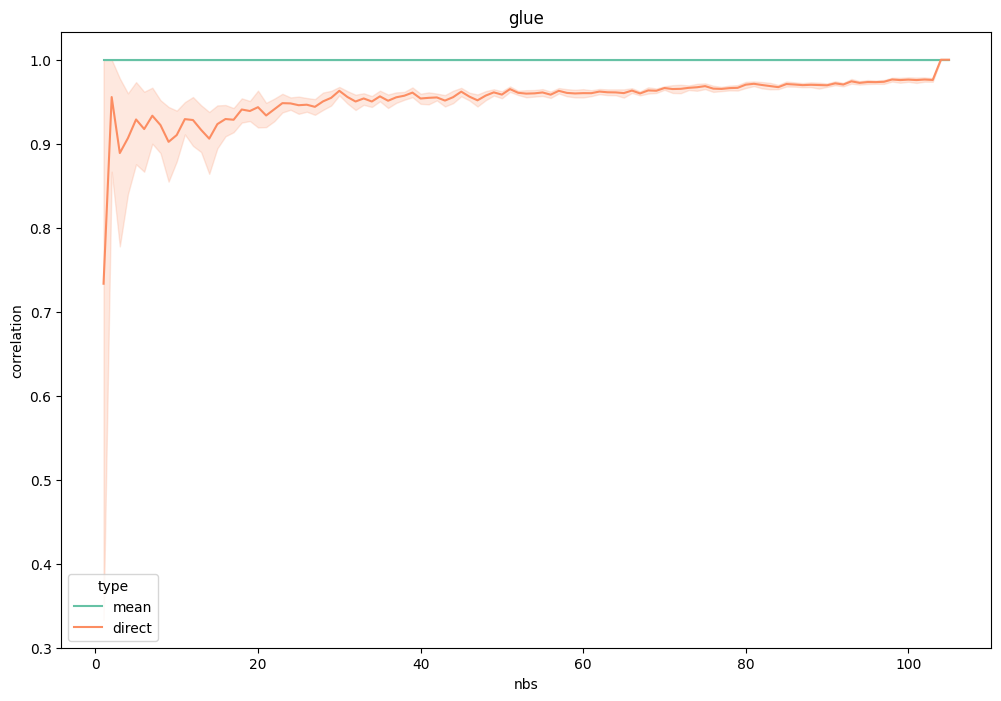

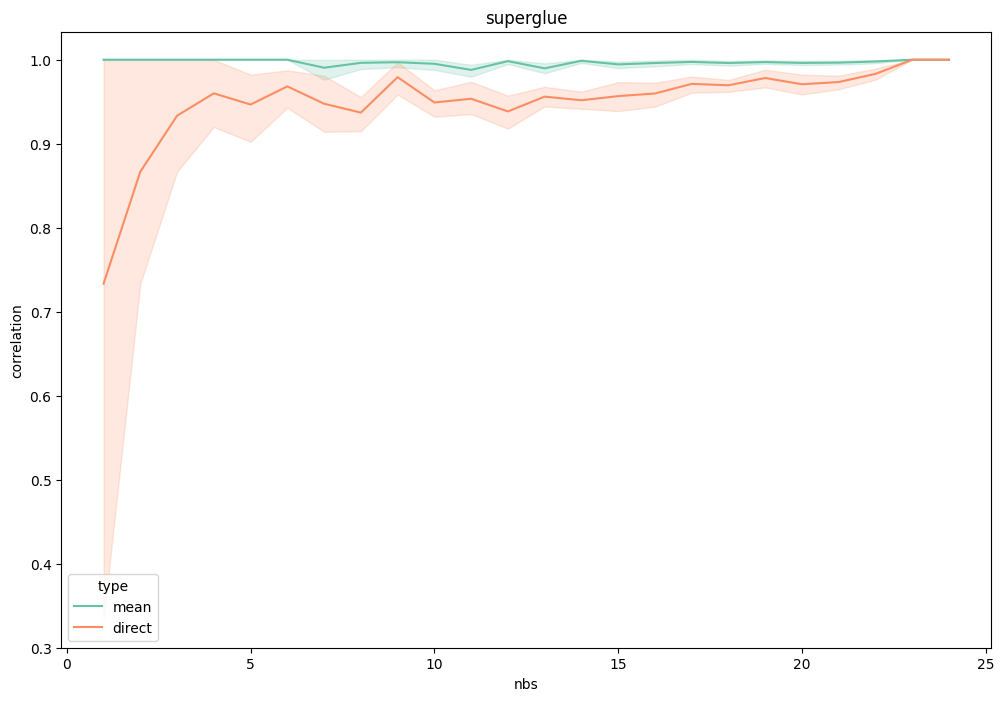

In [22]:
number_of_samples = 15
for ds in DATASETS: 
        df_dic = {
                'type':[],
                'correlation':[],
                'nbs':[]
            }
        with open('final_dic_ajout_de_systems_{}_{}_benchmarks.json'.format(ds,number_of_samples),'r') as file:
            l_final_dic = json.load(file)
        for index,c_dic in enumerate(l_final_dic):
            index_runing=index // number_of_samples 
            for k,v in c_dic.items():
                    df_dic['nbs'].append(index_runing)
                    df_dic['type'].append(k)
                    df_dic['correlation'].append(v)
        plt.figure(figsize=(12,8))
        df_to_plot = pd.DataFrame(df_dic)
        sns.lineplot(x="nbs", y="correlation", hue="type",data=df_to_plot)
        plt.title('{}'.format(ds))
        plt.show()

## Quantitative analysis via agrements/kendall correlation/kendall distance

In [23]:
def analyse_agreements_benchmark(data_path, type_of_agreement=1):
    final_to_plot = {
       'ds':[],
        'is_1':[], #is equal
        'is_3':[],
        'is_5':[],
        'is_10':[],
        '1':[],
        '3':[],
        '5':[],
        '10':[],
        'k_1':[],
        'k_3':[],
        'k_5':[],
        'k_10':[],
        'tau':[],
        'all':[],
        'method':[],
        }
    method = {'0':1}
    for ds in tqdm(DATASETS,'Datasets'):
        assert type_of_agreement in [1,-1]
        df =  pd.read_csv('data/{}.data'.format(ds),index_col=False)
        considered_df =  pd.read_csv('data/{}.data'.format(ds),index_col=False,usecols = [i for i in range(df.shape[1]) if i!=1])
       
        mean_ranking,means = mean_aggregation_task_level(considered_df)
        mean_reindex = np.argsort(-np.array(mean_ranking))
        df_new = df.reindex(mean_reindex,copy = False)
        df_new.reset_index(inplace=True)
        del df_new['index']
        # create rankings
        mean_ranking = mean_aggregation_task_level(df_new)[0]
        mean_aggreg = np.argsort(-np.array(mean_ranking))
        ranking_ranking  = ranking_aggregation(df_new)
        #ranking_ranking = [ranking_ranking.tolist().index(i) for i in range(len(ranking_ranking))]
        
        direct_aggreg = np.argsort(-np.array(ranking_ranking))
        #direct_aggreg = [direct_aggreg.tolist().index(i) for i in range(len(direct_aggreg))]
        
        comparizons = [(mean_aggreg,direct_aggreg)]
        print('Ds',ds)
        print('mean_ranking',mean_ranking)
        print('mean_aggreg',mean_aggreg)
        
        print('borda_ranking',ranking_ranking)
        print('borda_aggreg',direct_aggreg)
        for index, (a,b) in enumerate(comparizons):
            final_to_plot['ds'].append(ds)
            final_to_plot['method'].append(method[str(index)])
            if type_of_agreement == 1: #best
                final_to_plot['k_1'].append(stats.kendalltau(a[-1:], b[-1:])[0])
                final_to_plot['k_3'].append(stats.kendalltau(a[-3:], b[-3:])[0])
                final_to_plot['k_5'].append(stats.kendalltau(a[-5:], b[-5:])[0])
                final_to_plot['k_10'].append(stats.kendalltau(a[-10:], b[-10:])[0])
                final_to_plot['all'].append(stats.kendalltau(a, b)[0])
                final_to_plot['1'].append(pu.distance(a[-1:], b[-1:]))
                final_to_plot['3'].append(pu.distance(a[-3:], b[-3:]))
                final_to_plot['5'].append(pu.distance(a[-5:], b[-5:]))
                final_to_plot['10'].append(pu.distance(a[-10:], b[-10:]))
                final_to_plot['is_1'].append(a[-1: ] == b[-1:])
                final_to_plot['is_3'].append(a[-3:] == b[-3:])
                final_to_plot['is_5'].append(a[-5:] == b[-5:])
                final_to_plot['tau'].append(stats.kendalltau(a, b)[0])
                final_to_plot['is_10'].append(a[-10:] == b[-10:])

            else : #worst
                final_to_plot['k_1'].append(stats.kendalltau(a[:1], b[:1])[0])
                final_to_plot['k_3'].append(stats.kendalltau(a[:3], b[:3])[0])
                final_to_plot['k_5'].append(stats.kendalltau(a[:5], b[:5])[0])
                final_to_plot['k_10'].append(stats.kendalltau(a[:10], b[:10])[0])
                final_to_plot['tau'].append(stats.kendalltau(a, b)[0])
                final_to_plot['all'].append(stats.kendalltau(a, b)[0])
                final_to_plot['1'].append(pu.distance(a[:1], b[:1]))
                final_to_plot['3'].append(pu.distance(a[:3], b[:3]))
                final_to_plot['5'].append(pu.distance(a[:5], b[:5]))
                final_to_plot['10'].append(pu.distance(a[:10], b[:10]))  
                final_to_plot['is_1'].append(a[0] == b[0])
                final_to_plot['is_3'].append(a[:3] == b[:3])
                final_to_plot['is_5'].append(a[:5] == b[:5])
                final_to_plot['is_10'].append(a[:10] == b[:10])
    return final_to_plot

In [24]:
final_to_plot=  analyse_agreements_benchmark(data_path = 'final_df', type_of_agreement=-1)  
data_df = pd.DataFrame(final_to_plot)

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Ds xtrem
mean_ranking [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
mean_aggreg [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
borda_ranking [14 13  6 12 11 10  8  7  9  4  5  3  2  1  0]
borda_aggreg [ 0  1  3  4  5  8  6  7  2 10  9 11 12 13 14]
Ds glue
mean_ranking [104 103 102 101 100  99  98  97  96  94  95  93  92  91  90  89  88  87
  86  85  84  83  82  80  81  79  77  76  78  75  74  73  72  71  70  69
  67  68  65  66  63  64  62  60  61  59  57  58  55  54  56  53  52  51
  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33
  32  31  30  29  28  27  23  26  25  24  21  22  20  19  18  17  16  15
  14  13  12  11  10   9   8   7   6   5   4   3   2   1   0]
mean_aggreg [  0   1   2   3   4   5   6   7   8  10   9  11  12  13  14  15  16  17
  18  19  20  21  22  24  23  25  28  26  27  29  30  31  32  33  34  35
  37  36  39  38  41  40  42  44  43  45  47  46  50  48  49  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71

In [25]:
data_df

,ds,is_1,is_3,is_5,is_10,1,3,5,10,k_1,k_3,k_5,k_10,tau,all,method
0,xtrem,True,"[True, True, False]","[True, True, False, False, False]","[True, True, False, False, False, False, True,...",0,0,0,8,NaN,1.0,1.0,0.644444,0.828571,0.828571,1
1,glue,True,"[True, True, True]","[True, True, True, True, False]","[True, True, True, True, False, False, False, ...",0,0,0,4,NaN,1.0,1.0,0.822222,0.916850,0.916850,1
2,superglue,True,"[True, True, True]","[True, True, True, True, False]","[True, True, True, True, False, False, True, T...",0,0,0,2,NaN,1.0,1.0,0.911111,0.913043,0.913043,1


In [26]:
final_to_plot=  analyse_agreements_benchmark(data_path = 'final_df', type_of_agreement=1)  
data_df =pd.DataFrame(final_to_plot)

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Ds xtrem
mean_ranking [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
mean_aggreg [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
borda_ranking [14 13  6 12 11 10  8  7  9  4  5  3  2  1  0]
borda_aggreg [ 0  1  3  4  5  8  6  7  2 10  9 11 12 13 14]
Ds glue
mean_ranking [104 103 102 101 100  99  98  97  96  94  95  93  92  91  90  89  88  87
  86  85  84  83  82  80  81  79  77  76  78  75  74  73  72  71  70  69
  67  68  65  66  63  64  62  60  61  59  57  58  55  54  56  53  52  51
  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33
  32  31  30  29  28  27  23  26  25  24  21  22  20  19  18  17  16  15
  14  13  12  11  10   9   8   7   6   5   4   3   2   1   0]
mean_aggreg [  0   1   2   3   4   5   6   7   8  10   9  11  12  13  14  15  16  17
  18  19  20  21  22  24  23  25  28  26  27  29  30  31  32  33  34  35
  37  36  39  38  41  40  42  44  43  45  47  46  50  48  49  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71

In [27]:
data_df

,ds,is_1,is_3,is_5,is_10,1,3,5,10,k_1,k_3,k_5,k_10,tau,all,method
0,xtrem,[True],"[True, True, True]","[False, True, True, True, True]","[False, True, True, False, False, False, True,...",0,0,0,6,NaN,1.000000,1.0,0.733333,0.828571,0.828571,1
1,glue,[False],"[True, False, False]","[False, False, True, False, False]","[False, False, False, False, False, False, Fal...",0,1,1,8,NaN,0.333333,0.8,0.644444,0.916850,0.916850,1
2,superglue,[True],"[True, True, True]","[False, False, True, True, True]","[False, False, True, False, False, False, Fals...",0,0,1,6,NaN,1.000000,0.8,0.733333,0.913043,0.913043,1


#### Display with barplot

Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Ds xtrem
mean_ranking [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
mean_aggreg [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
borda_ranking [14 13  6 12 11 10  8  7  9  4  5  3  2  1  0]
borda_aggreg [ 0  1  3  4  5  8  6  7  2 10  9 11 12 13 14]
Ds glue
mean_ranking [104 103 102 101 100  99  98  97  96  94  95  93  92  91  90  89  88  87
  86  85  84  83  82  80  81  79  77  76  78  75  74  73  72  71  70  69
  67  68  65  66  63  64  62  60  61  59  57  58  55  54  56  53  52  51
  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33
  32  31  30  29  28  27  23  26  25  24  21  22  20  19  18  17  16  15
  14  13  12  11  10   9   8   7   6   5   4   3   2   1   0]
mean_aggreg [  0   1   2   3   4   5   6   7   8  10   9  11  12  13  14  15  16  17
  18  19  20  21  22  24  23  25  28  26  27  29  30  31  32  33  34  35
  37  36  39  38  41  40  42  44  43  45  47  46  50  48  49  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71

<AxesSubplot: xlabel='k_1', ylabel='ds'>

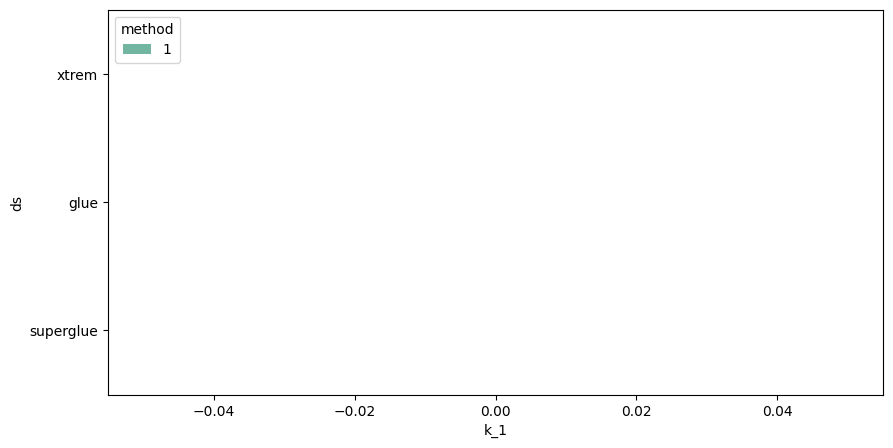

In [28]:
final_to_plot=  analyse_agreements_benchmark(data_path = 'final_df', type_of_agreement=-1)  
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(10,5))
sns.barplot(x = 'k_1', y = 'ds', hue = 'method', data = data_df)

<AxesSubplot: xlabel='k_3', ylabel='ds'>

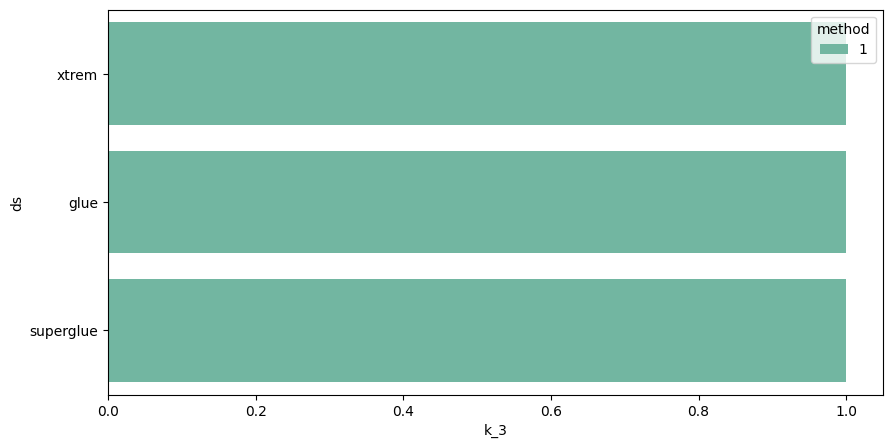

In [29]:
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(10,5))
sns.barplot(x = 'k_3', y = 'ds', hue = 'method', data = data_df)

<AxesSubplot: xlabel='k_5', ylabel='ds'>

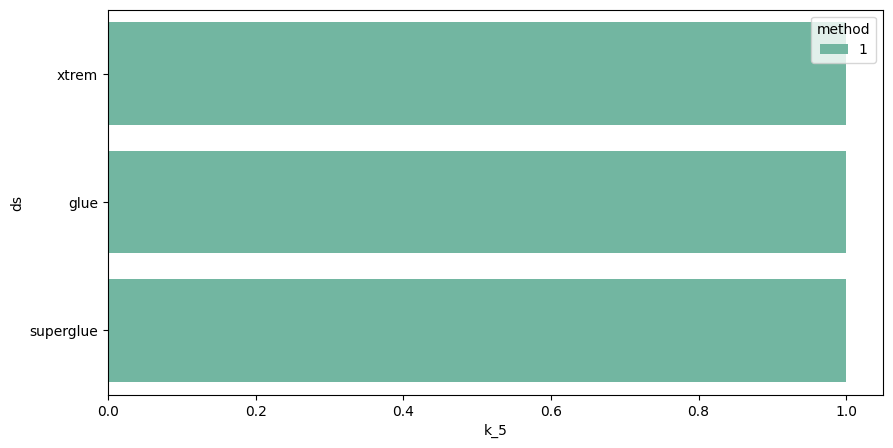

In [30]:
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(10,5))
sns.barplot(x = 'k_5', y = 'ds', hue = 'method', data = data_df)

<AxesSubplot: xlabel='k_10', ylabel='ds'>

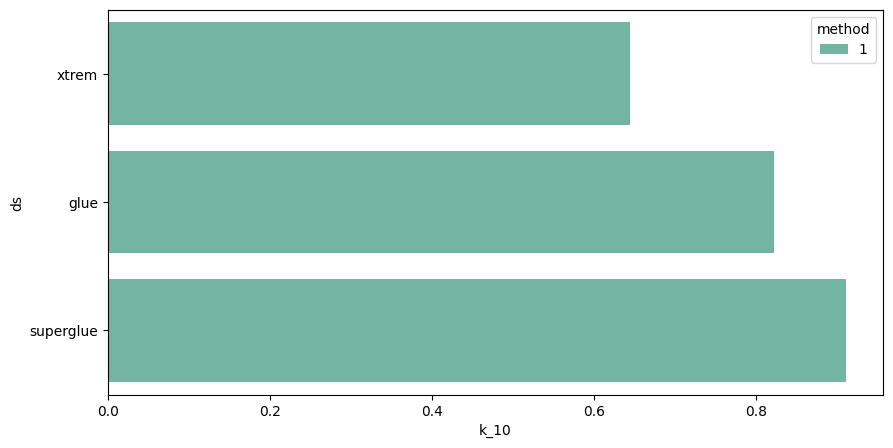

In [31]:
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(10,5))
sns.barplot(x = 'k_10', y = 'ds', hue = 'method', data = data_df)

<AxesSubplot: xlabel='is_1', ylabel='ds'>

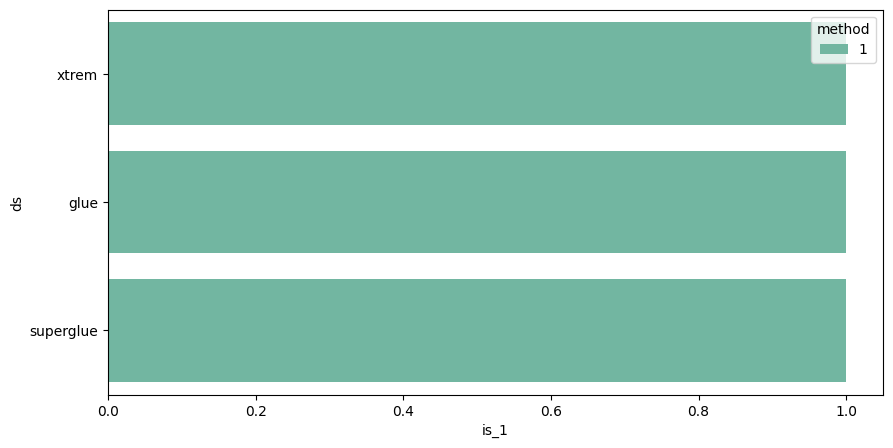

In [32]:
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(10,5))
sns.barplot(x = 'is_1', y = 'ds', hue = 'method', data = data_df)